In [1]:
#This section is just standard imports, defining default plot settings,
# and defining constants
#standard imports
import numpy as np
import pandas as pd
import math
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import time
import matplotlib.cm as cm
import matplotlib as mpl
from os import listdir

import sys
#sys.path.append('../../')
import PLtools


#change default plot settings
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 28}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

#Constants
pi = math.pi
heV = 4.14e-15 #eV*s
c = 2.99792e8 #m/s
kbeV = 8.6173e-5 #eV/K
keV = 8.6173e-5 #eV/K
h = 6.626e-34
kb = 1.38065e-23
q = 1.60218e-19

In [2]:
#This section we define inputs 
#Inputs Here
directory = '../../data/PLdata/2018_10-12PL'
laser_power = 32*1e-9
grating = '500nm' # '500nm' or '1200nm' or '1200nm-InGaAs
#dname = 'Dark.txt' #assumes 1 dark name per folder

#Now lets look into the directory to see what files we have to analyze
#(this avoids having to copy/paste filenames)
names = []
for file in listdir(directory):
    if file[-6:] == 'XY.txt':
        names.append(file)
    elif file[-8:] == 'Dark.txt':
        dname = file
        
print(names)
print(dname)

['2018_10-12 FAGACs 1p25TOPO 2p5PEAI XY.txt', '2018_10-12 FAGACs 1p25TOPO XY.txt', '2018_10-12 FAGACs 2p5PEAI XY.txt', '2018_10-12 FAGACs 2p5TOPO 2p5PEAI XY.txt', '2018_10-12 FAGACs 2p5TOPO XY.txt', '2018_10-12 FAGACs p625TOPO 2p5PEAI XY.txt', '2018_10-12 FAGACs p625TOPO XY.txt', '2018_10-12 FAGACs XY.txt']
2018_10-12 Dark.txt


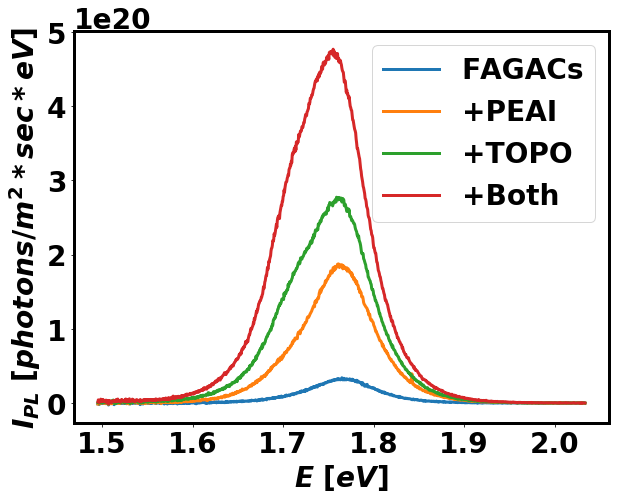

In [3]:
#Use Case 1: We want to took at a few PL maps, convert to absolute units,
#then plot 1 spectrum per map on same plot. 
for ii in (7, 2, 1, 0):
    #Load data, using pd. Can also use np.loadtxt, but less flexible
    df = pd.read_table(directory + '/' + dname,header=None)
    dark = df.values    
    df = pd.read_table(directory + '/' + names[ii],header=None)
    data = df.values
    
    #Convert to aboslute units with single line of code, calling function from
    #PLtools module
    aipl_data = PLtools.aipl(data,dark,grating)
    
    #Lets choose the peak with median PLQY. There is a function in PLtools 
    #that returns index to median PLQY spectrum
    idx = PLtools.med_idx(aipl_data)
    
    #Look at map data to see where AIPL info is, and also to find E
    k = 0
    while np.isnan(aipl_data[0,k]):
        k = k + 1
    lam = aipl_data[0,k:]
    E = heV*c/(lam*1e-9)
    spectrum = aipl_data[idx,k:]
    
    #Now prepare plot
    plt.plot(E,spectrum,'-',linewidth=3)
plt.xlabel('$E\ [eV]$')
plt.ylabel('$I_{PL}\ [photons/m^2*sec*eV]$')
plt.legend(['FAGACs','+PEAI','+TOPO','+Both'])
plt.show()

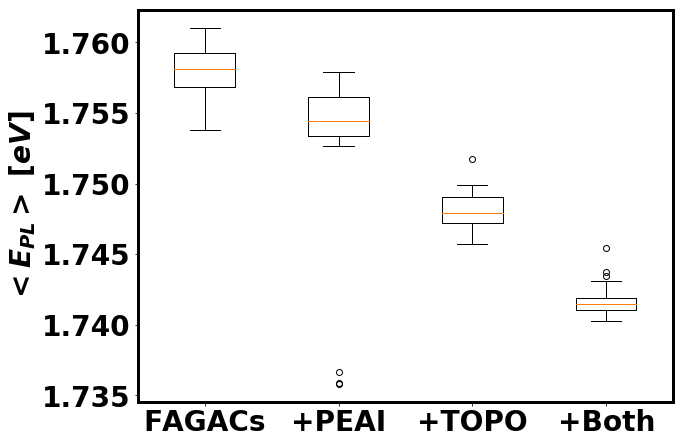

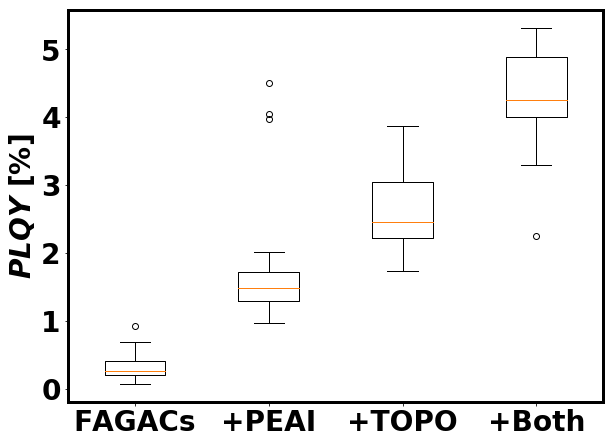

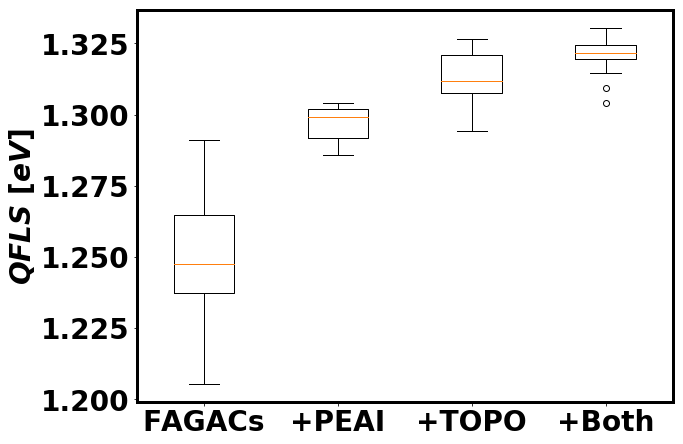

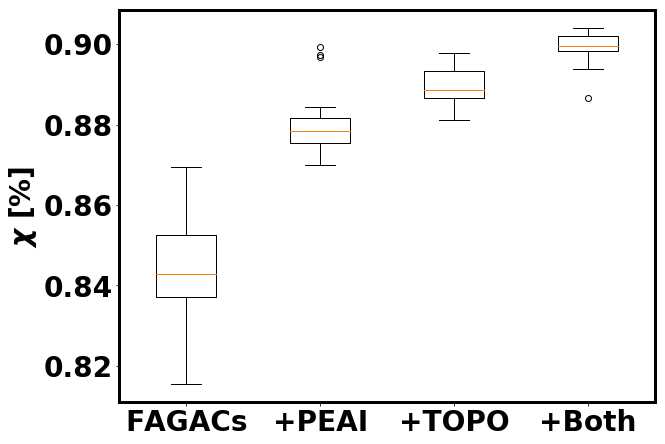

In [4]:
#Use Case 2: Lets look at maps, calculate QFLS and chi with PLQY method,
#then plot distributions

#Pre-allocate lists, we will use these to plot
meanPL_list = []
PLQY_list = []
QFLS_list = []
chi_list = []
for ii in (7, 2, 1, 0):
    #Load data, using pd. Can also use np.loadtxt, but less flexible
    df = pd.read_table(directory + '/' + dname,header=None)
    dark = df.values
    df = pd.read_table(directory + '/' + names[ii],header=None)
    data = df.values
    
    #Convert to aboslute units with single line of code, calling function from
    #PLtools module
    aipl_data = PLtools.aipl(data,dark,grating)
    
    #Determine PL params using PLtools.plqy_ext function
    (mean_Ipl, peak_pos, FWHM, 
     PLQY, dmu_PLQY, chi_PLQY,
     dmu_PLQY_Eg, chi_PLQY_Eg) = PLtools.plqy_ext(aipl_data, laser_power)
    
    #We will make a list for each param we want to plot (a list of np arrays)
    #Exclude 0 entries (datapoints that were skipped)
    meanPL_list.append(mean_Ipl[np.where(mean_Ipl>0)])
    PLQY_list.append(100*PLQY[np.where(PLQY>0)])
    QFLS_list.append(dmu_PLQY[np.where(dmu_PLQY>0)])
    chi_list.append(chi_PLQY[np.where(chi_PLQY>0)])
    
#Make 4 different boxplots for each parameter
plt.figure()
plt.boxplot(meanPL_list)
#plt.ylim(1.7,1.8)
plt.ylabel('$<E_{PL}>\ [eV]$')
plt.xticks([1, 2, 3, 4], ['FAGACs', '+PEAI', '+TOPO', '+Both'])
plt.show()

plt.figure()
plt.boxplot(PLQY_list)
#plt.ylim(1.7,1.8)
plt.ylabel('$PLQY\ [\%]$')
plt.xticks([1, 2, 3, 4], ['FAGACs', '+PEAI', '+TOPO', '+Both'])
plt.show()

plt.figure()
plt.boxplot(QFLS_list)
#plt.ylim(1.7,1.8)
plt.ylabel('$QFLS\ [eV]$')
plt.xticks([1, 2, 3, 4], ['FAGACs', '+PEAI', '+TOPO', '+Both'])
plt.show()

plt.figure()
plt.boxplot(chi_list)
#plt.ylim(1.7,1.8)
plt.ylabel('$\chi\ [\%]$')
plt.xticks([1, 2, 3, 4], ['FAGACs', '+PEAI', '+TOPO', '+Both'])
plt.show()

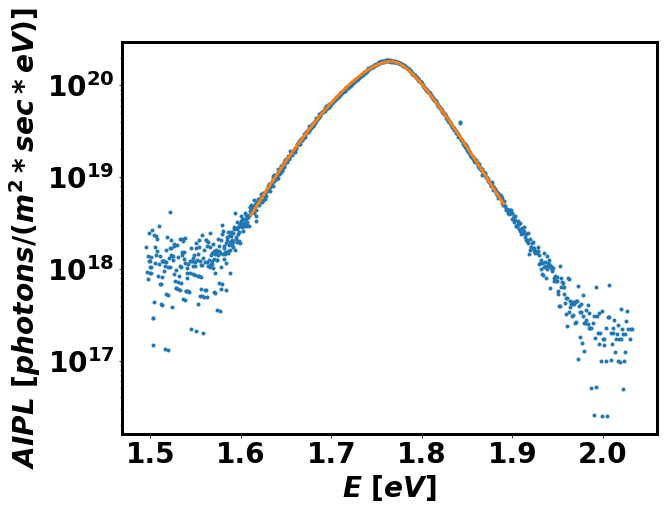

In [5]:
#Use Case 3: Study Full Peak Fit for a single spectrum
#Lets do + PEAI and choose the peak with median PLQY
ii = 2 #+PEAI filename index

#Load data, using pd. Can also use np.loadtxt, but less flexible
df = pd.read_table(directory + '/' + dname,header=None)
dark = df.values
df = pd.read_table(directory + '/' + names[ii],header=None)
data = df.values

#Convert to aboslute units with single line of code, calling function from
#PLtools module
aipl_data = PLtools.aipl(data,dark,grating)

#Lets choose the peak with median PLQY. There is a function in PLtools 
#that returns index to median PLQY spectrum
idx = PLtools.med_idx(aipl_data)

#Look at map data to see where AIPL info is, and also to find E
k = 0
while np.isnan(aipl_data[0,k]):
    k = k + 1
lam = aipl_data[0,k:]
E = heV*c/(lam*1e-9)
Ipl = aipl_data[idx,k:]

#Use full_peak_fit to make a full peak fit
d = 375/(1e7) #cm
X0 = [1.5,.037,1e5,1.75,1.4,288,d]
(Emod, aipl_mod, theta, gam, Eg, QFLS, T) = PLtools.full_peak_fit(E,Ipl,X0)


plt.semilogy(E,Ipl,'.',Emod,aipl_mod,linewidth=3)
plt.xlabel('$E\ [eV]$')
plt.ylabel('$AIPL\ [photons/(m^2*sec*eV)]$')
plt.show()

In [6]:
PLtools.aipl?
